In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import os
from tqdm.notebook import tqdm

In [5]:
def getVar(simn, var, iter):
    file = open(f'sims/sim{simn}/mesh_fc_{iter}.vtk')
    # file = open(f'sims/sim_looong_5/plateMesh_{i}.vtk')
    arr = []
    lines = file.readlines()
    j = 0
    while f'SCALARS {var} double 1\n' != lines[j]:
        j += 1
    j += 2
    while True:
        try:
            arr.append(float(lines[j]))
            j += 1
        except:
            break
    return np.array(arr)

def getVarHist(simn, var, iter=None):
    arrs = []
    if iter is None:
        iter = 500
    for i in range(iter+1):
        try:
            arrs.append(getVar(simn, var, i))
        except:
            continue
    return np.array(arrs)

def getMainAxis(arrs, n, m):
    i = np.arange(m-1)*n + int(n*3/8)
    i = i[:,None] + np.concatenate([np.arange(-5, 5), np.arange(-5, 5) + n//2])[None,:]
    return np.max(arrs[...,i], axis=-1)

def getN(arrs):
    arrs[arrs == 0] = 1e18
    return np.cumsum(np.min(arrs, axis=1))

def getCrackLen(psis):
    return np.argmax(psis < 0.5, axis=-1)

u = 3.37e8
uw = 2.5e8
b = 1.16e9
bl = 1 / 0.31
bv = 1 / 0.27

def dn(x):
    # double sigmaFrac_l = std::max(sigma_eq(i) - sigma_u, 0.0)/(sigma_b - sigma_u);
    # double sigmaFrac_v = std::max(sigma_eq(i) - sigma_uw, 0.0)/(sigma_u - sigma_uw);
    # B(i) = std::max(1e-3 * std::pow(sigmaFrac_l, 1/beta_l) / (2*alpha),
    #                 1e-8 * std::pow(sigmaFrac_v, 1/beta_v) / (2*alpha));
    fl = np.maximum(x - u, 0) / (b - u)
    fv = np.maximum(x - uw, 0) / (u - uw)
    B = np.maximum(1e-3 * fl ** bl, 1e-8 * fv ** bv)
    # dn(i) = 0.5/(alpha*B(i)) * (p2(1-std::pow(psi(i), alpha)) - p2(1-std::pow(std::min(1.0, psi(i) + dPsi0), alpha)));
    return 1 / B

In [14]:
for i in range(0, 12, 2):
    psi = getMainAxis(getVarHist(f'ampl{30+i}', 'psi'), 100, 18).min(axis=-1)
    k = np.argmax(psi > 0.5)
    n = getN(getVarHist(f'ampl{30+i}', 'deltaN'))[k]
    print(f'ampl{30+i}', psi[k], k, n)

ampl30 0.507408 91 11557693.9
ampl32 0.576699 89 3439394.13
ampl34 0.587918 93 1172170.8
ampl36 0.513292 74 990548.97
ampl38 0.595238 96 286221.31000000006
ampl40 0.516218 98 169004.986


In [6]:
for i in range(1, 5):
    psi = getMainAxis(getVarHist(f'2dh{i}', 'psi'), i*100, (i*35+1)//2).min(axis=-1)
    k = np.argmax(psi > 0.5)
    if k == 0:
        k = len(psi)-1
    print(f'2dh{i}', k, getN(getVarHist(f'2dh{i}', 'deltaN'))[k])

2dh1 98 169004.986
2dh2 252 181575.98040000003
2dh3 399 231143.22509999987
2dh4 299 200037.11834000002


In [72]:
dn(462e6)

436807.1604805852

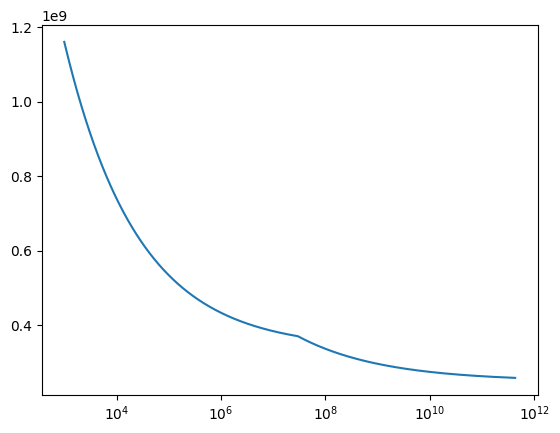

In [80]:
x = np.linspace(uw+(b-uw)*0.01, b, 10000)
plt.plot(dn(x), x)
plt.xscale('log')

In [43]:
f = 5e6
om = f * np.pi * 2
A = 0.75e-6
E = 1.16e11
nu = 0.32
lam = nu*E/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)
rho = 4500
c = np.sqrt(E*(1-nu)/(1+nu)/(1-2*nu)/rho)
k = f/c

print(k)
2*2*(lam + 2*mu) * k * A / 1e8

823.24864817016


4.0996119550291805

In [31]:
2*(lam+2*mu) / 1e9

331.986531986532

In [37]:
name = 'ampl60.1'
psi = getMainAxis(getVarHist(name, 'psi'), 100, 18).min(axis=-1)
k = np.argmax(psi > 0.5)
n = getN(getVarHist(name, 'deltaN'))[k]
print(name, psi[k], k, n)

ampl60.1 0.507408 91 11557693.9


In [84]:
for i in range(50, 85, 5):
    name = f'2ampl{i}'
    psi = getMainAxis(getVarHist(name, 'psi'), 200, 35)
    k = np.argmax(psi.min(axis=-1) > 0.5)
    l = np.argmax(psi < 0.5, axis=1)
    n = getN(getVarHist(name, 'deltaN'))
    print(name, k, f'{n[k]:.3e}')
    # plt.plot(n, l + psi[range(psi.shape[0]), l])
    # plt.xlim(0, n[np.argmax(l)])
    # plt.show()

2ampl50 159 6.368e+09
2ampl55 161 4.732e+08
2ampl60 224 4.854e+07
2ampl65 0 9.724e+04
2ampl70 0 4.920e+04
2ampl75 283 4.076e+05
2ampl80 252 1.816e+05


In [32]:
A = np.arange(50, 85, 5) * 1e-8
ns = [6.37e9, 4.73e8, 4.85e7, 8.72e6, 1.52e6, 4.08e5, 1.81e5]
sigmas = A * 4.62e8 / 80e-8
tn = dn(sigmas)
tn

array([1.99947895e+09, 2.54231603e+08, 6.81245237e+07, 1.97097940e+07,
       3.22651747e+06, 1.01922319e+06, 4.36807160e+05])

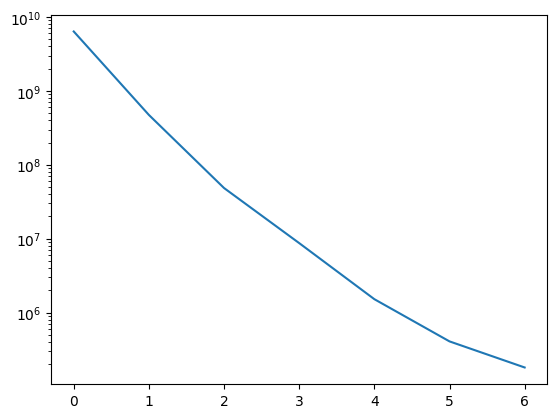

In [33]:
plt.plot(ns)
plt.yscale('log')

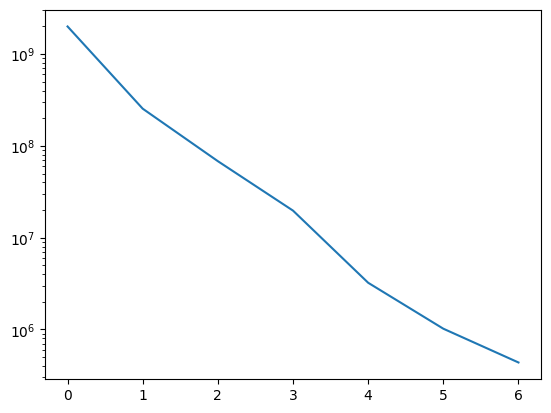

In [19]:
plt.plot(tn)
plt.yscale('log')

In [29]:
print(pd.DataFrame({'s' : sigmas, 't' : tn, 'n' : ns, 'A' : A*1.5}).to_latex(index=False))

\begin{tabular}{rrrr}
\toprule
          s &            t &            n &            A \\
\midrule
288750000.0 & 1.999479e+09 & 6370000000.0 & 7.500000e-07 \\
317625000.0 & 2.542316e+08 &  473000000.0 & 8.250000e-07 \\
346500000.0 & 6.812452e+07 &   48500000.0 & 9.000000e-07 \\
375375000.0 & 1.970979e+07 &    6720000.0 & 9.750000e-07 \\
404250000.0 & 3.226517e+06 &    1520000.0 & 1.050000e-06 \\
433125000.0 & 1.019223e+06 &     408000.0 & 1.125000e-06 \\
462000000.0 & 4.368072e+05 &     181000.0 & 1.200000e-06 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_9292/2191751432.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame({'s' : sigmas, 't' : tn, 'n' : ns, 'A' : A*1.5}).to_latex(index=False))


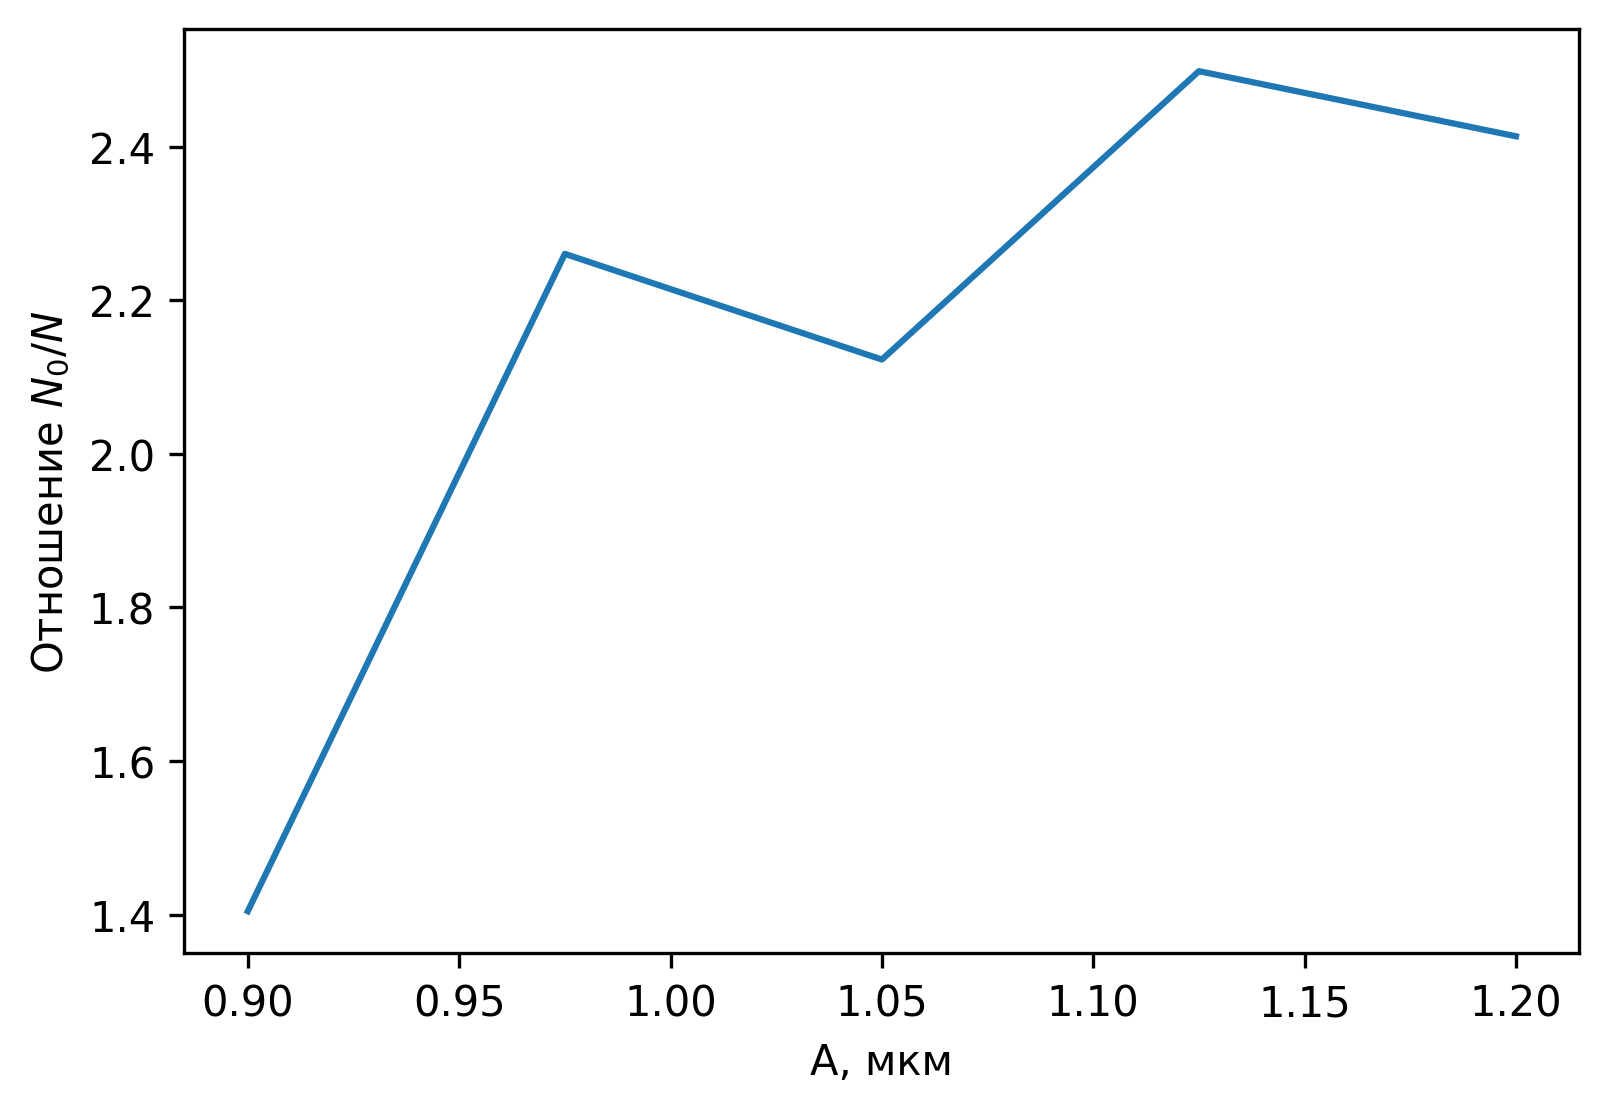

In [38]:
plt.figure(figsize=(6,4), dpi=300)

plt.plot(A[2:]*1.5e6, (tn/ns)[2:])
plt.xlabel('A, мкм')
plt.ylabel('Отношение $N_0/N$')
plt.savefig('n0n.pdf')
plt.show()

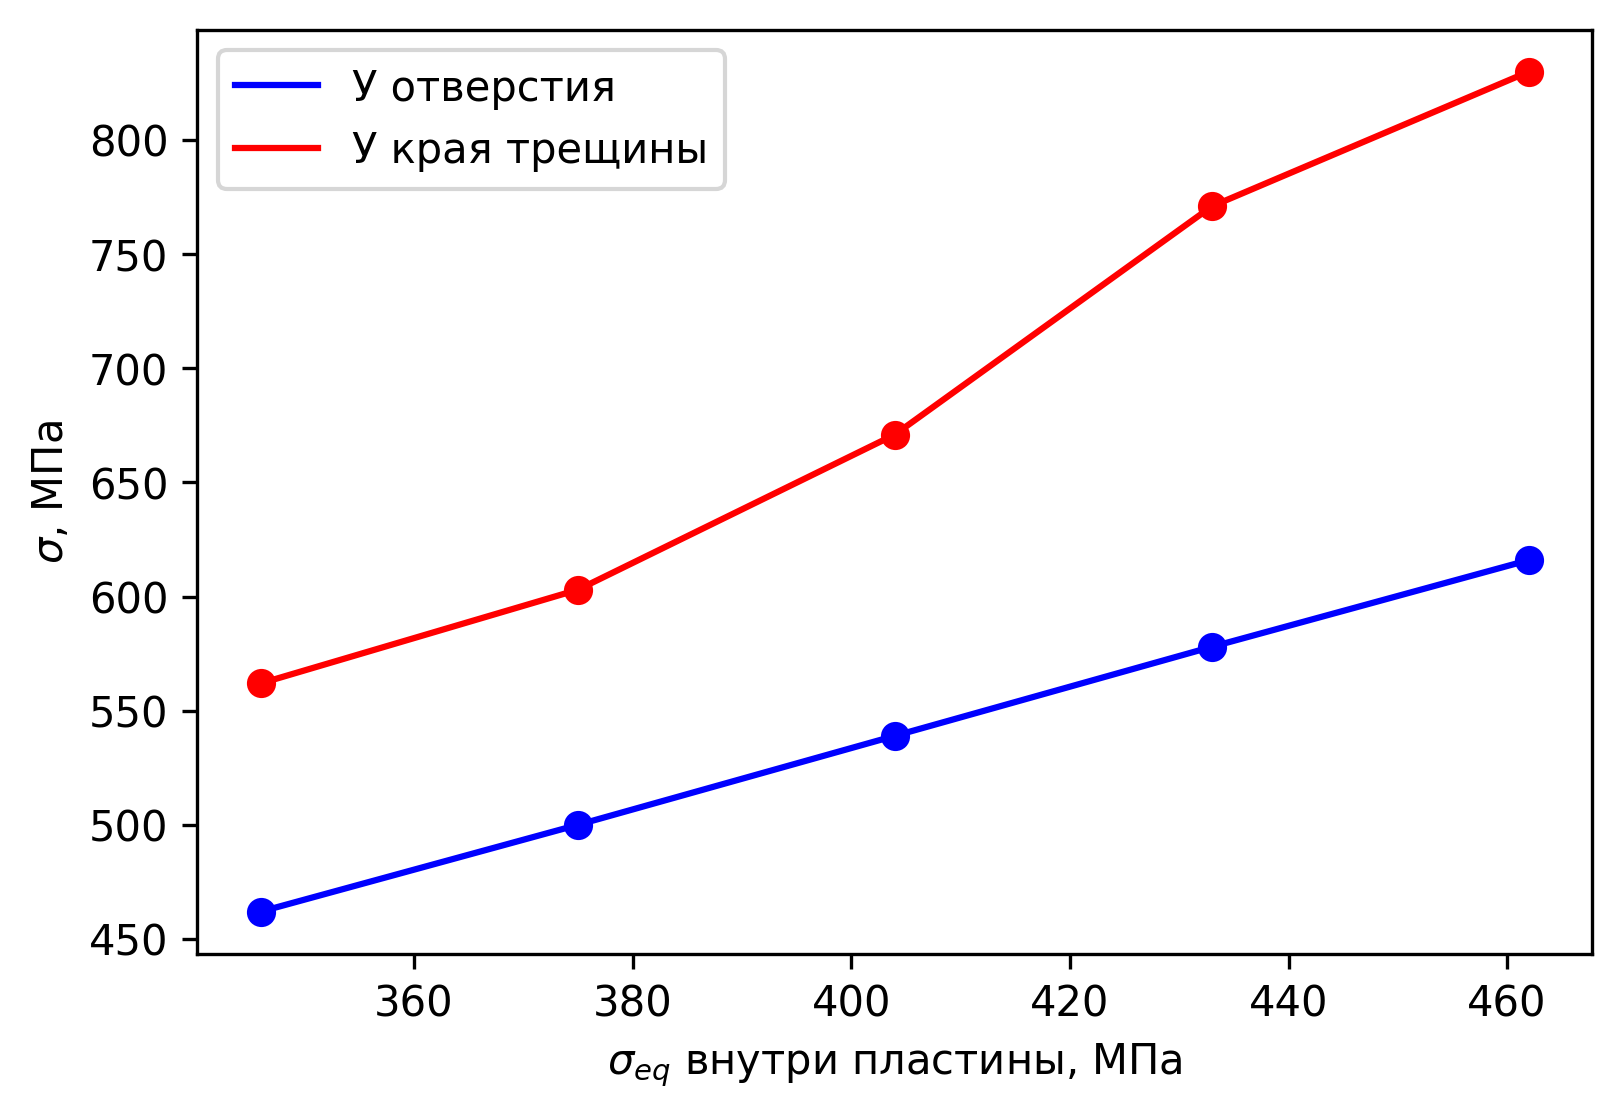

In [61]:
plt.figure(figsize=(6,4), dpi=300)
s1 = np.array([346, 375, 404, 433, 462])
s2 = np.array([462, 500, 539, 578, 616])
s3 = np.array([562, 603, 671, 771, 830])
plt.plot(s1, s2, 'bo')
plt.plot(s1, s2, 'b-', label='У отверстия')
plt.plot(s1, s3, 'r-', label='У края трещины')
plt.plot(s1, s3, 'ro')
plt.xlabel('$\sigma_{eq}$ внутри пластины, МПа')
plt.ylabel('$\sigma$, МПа')
plt.legend()

plt.savefig('sigmas.pdf')
plt.show()

In [57]:
462/346


1.3352601156069364

In [59]:
616/462

1.3333333333333333